In [8]:
import os
import certifi

# Fix SSL certificate issue permanently
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['SSL_CERT_FILE'] = certifi.where()

import urllib3
urllib3.disable_warnings()  # Optional: suppress warnings

# Create directories
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../notebooks/figures', exist_ok=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from io import BytesIO
from zipfile import ZipFile

sns.set_style('whitegrid')
print("Environment ready with SSL fix!")

Environment ready with SSL fix!


In [9]:
# Cell 2: Download with SSL verification disabled (temporary workaround)
import requests
from io import BytesIO
from zipfile import ZipFile
import os

url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
raw_path = '../data/raw/complaints.csv'

if not os.path.exists(raw_path):
    print("Downloading dataset (ignoring SSL for now)...")
    # TEMPORARY: Disable SSL verification (safe for this trusted public site)
    response = requests.get(url, verify=False)  # ← This line bypasses the cert error
    with ZipFile(BytesIO(response.content)) as zipfile:
        zipfile.extractall('../data/raw')
    print("Dataset downloaded and extracted successfully!")
else:
    print("Dataset already exists.")

Dataset already exists.


In [10]:
# Load the DataFrame after downloading the dataset
df = pd.read_csv(raw_path)  # Load the CSV file into a DataFrame


Missing Values Summary:


,Count,Percent
Tags,12100078,94.548354
Consumer disputed?,12029483,93.996734
Consumer complaint narrative,9178196,71.717168
Company public response,6123754,47.850176
Consumer consent provided?,2003782,15.657278
Sub-issue,876689,6.850328
Sub-product,235295,1.838563
State,58331,0.455790
ZIP code,30229,0.236205
Company response to consumer,20,0.000156



Unique Values in Key Columns:
Product: 21 unique values
Product
Credit reporting or other personal consumer reports                             7707824
Credit reporting, credit repair services, or other personal consumer reports    2163844
Debt collection                                                                  960467
Mortgage                                                                         435891
Checking or savings account                                                      331395
Name: count, dtype: int64
Issue: 178 unique values
Issue
Incorrect information on your report                                                5336674
Improper use of your report                                                         2467836
Problem with a company's investigation into an existing problem                     1445571
Problem with a credit reporting company's investigation into an existing problem     589330
Attempts to collect debt not owed                                     

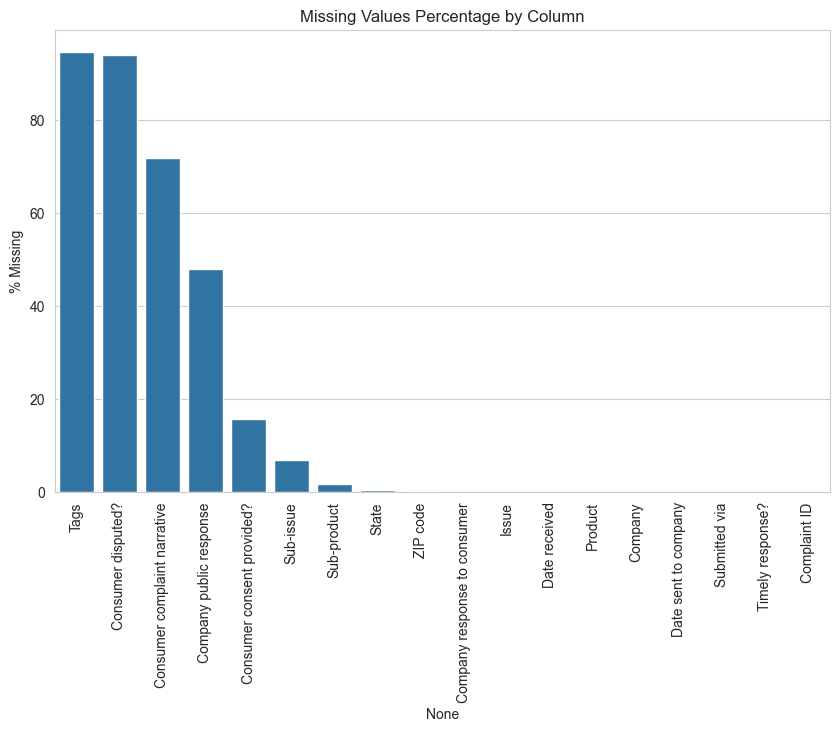

In [11]:
# Cell 4: Initial EDA - Overview, Missing Values, Unique Counts
print("\nMissing Values Summary:")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percent': missing_pct})
display(missing_df[missing_df['Count'] > 0])

# Unique values in key categorical columns
print("\nUnique Values in Key Columns:")
for col in ['Product', 'Issue', 'Sub-issue', 'Company', 'State']:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(5))  # Top 5

# Save missing summary plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_pct.index, y=missing_pct.values)
plt.xticks(rotation=90)
plt.title('Missing Values Percentage by Column')
plt.ylabel('% Missing')
plt.savefig('../notebooks/figures/missing_values.png')
plt.show()


Narrative Word Count Stats:


count    1.279777e+07
mean     5.048810e+01
std      1.424205e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.600000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64

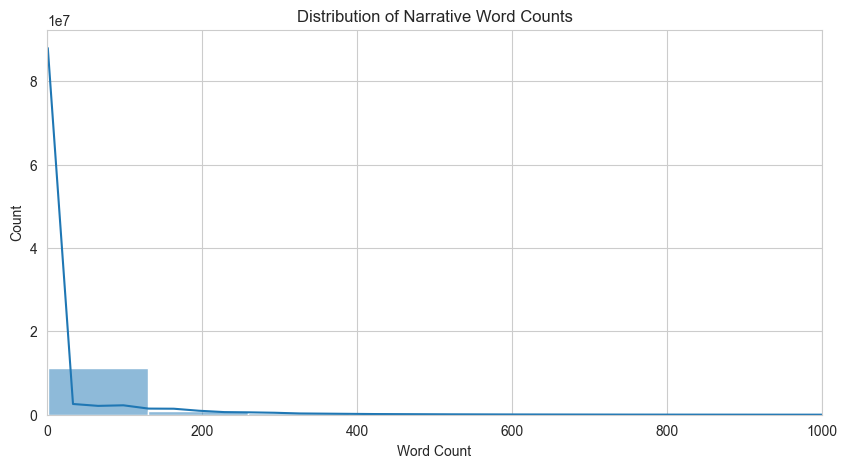

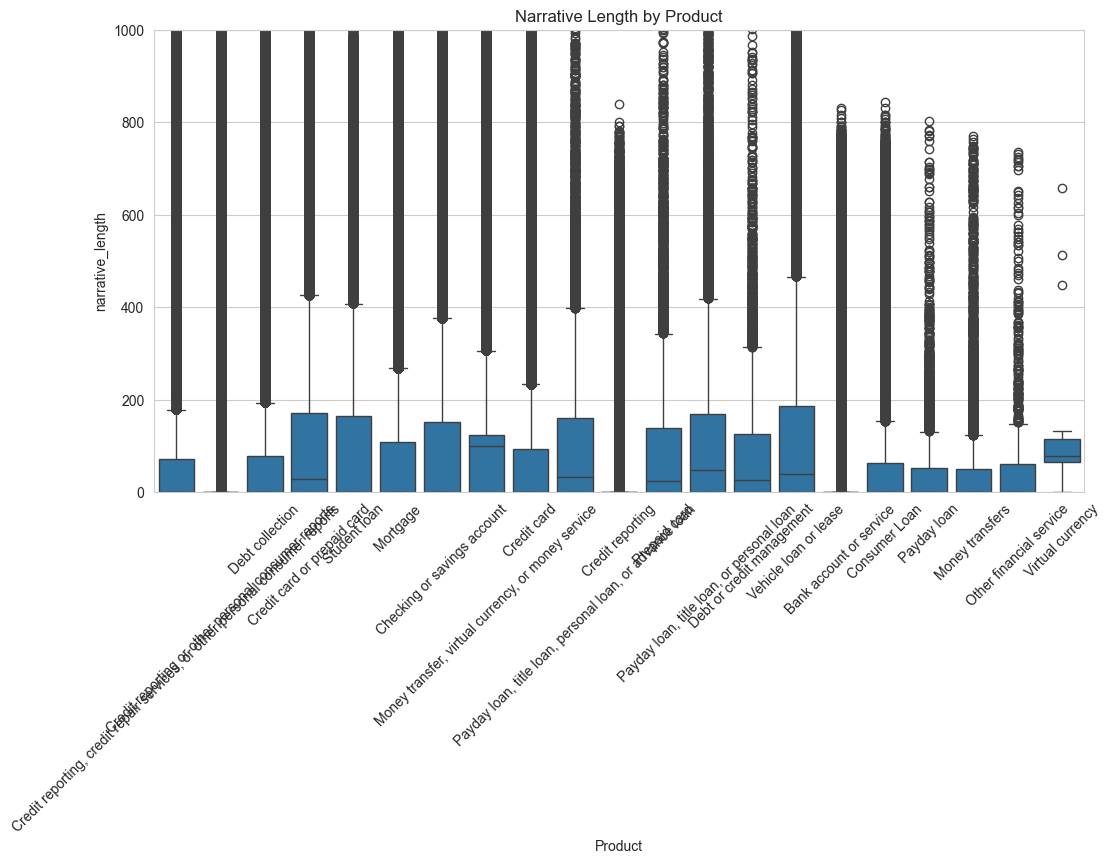

In [12]:
# Cell 5: Narrative Length Analysis
narrative_col = 'Consumer complaint narrative'  # Standard CFPB column
if narrative_col in df.columns:
    df['narrative_length'] = df[narrative_col].astype(str).apply(lambda x: len(x.split()) if pd.notna(x) else 0)
    
    print("\nNarrative Word Count Stats:")
    display(df['narrative_length'].describe())
    
    # Visualize distribution
    plt.figure(figsize=(10,5))
    sns.histplot(df['narrative_length'], bins=50, kde=True)
    plt.title('Distribution of Narrative Word Counts')
    plt.xlabel('Word Count')
    plt.xlim(0, 1000)  # Trim long tail
    plt.savefig('../notebooks/figures/narrative_length_hist.png')
    plt.show()
    
    # Boxplot by product (optional)
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Product', y='narrative_length', data=df)
    plt.xticks(rotation=45)
    plt.title('Narrative Length by Product')
    plt.ylim(0, 1000)
    plt.savefig('../notebooks/figures/narrative_length_by_product.png')
    plt.show()
else:
    print("No narrative column found.")


Complaints With Narrative: 3619571
Without Narrative: 9178196


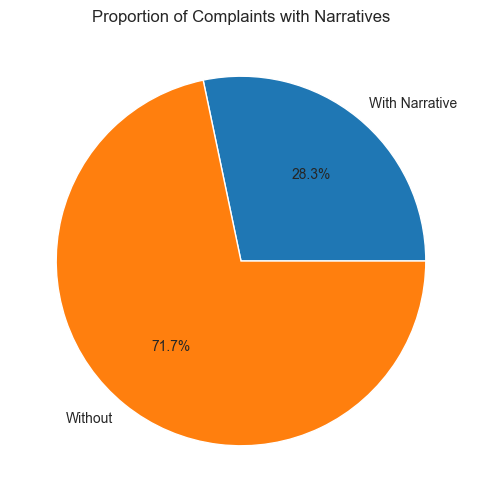

In [13]:
# Cell 6: Complaints With/Without Narratives
if narrative_col in df.columns:
    has_narrative = df[narrative_col].notna() & (df[narrative_col].str.strip() != '')
    print("\nComplaints With Narrative:", has_narrative.sum())
    print("Without Narrative:", len(df) - has_narrative.sum())
    
    # Pie chart
    plt.figure(figsize=(6,6))
    plt.pie([has_narrative.sum(), len(df) - has_narrative.sum()], labels=['With Narrative', 'Without'], autopct='%1.1f%%')
    plt.title('Proportion of Complaints with Narratives')
    plt.savefig('../notebooks/figures/has_narrative_pie.png')
    plt.show()

In [14]:
# Cell 7: Filter to 5 Products and Remove Empty Narratives
product_mapping = {
    'Credit card or prepaid card': 'Credit Cards',
    'Consumer Loan': 'Personal Loans',
    'Bank account or service': 'Savings Accounts',
    'Money transfer, virtual currency, or money service': 'Money Transfers'
    # Add if needed, e.g., 'Checking or savings account' for Savings
}

if 'Product' in df.columns and narrative_col in df.columns:
    # Filter products
    df_filtered = df[df['Product'].isin(product_mapping.keys())].copy()
    df_filtered['Product_Category'] = df_filtered['Product'].map(product_mapping)  # Standardize names
    
    # Remove empty narratives
    df_filtered = df_filtered[df_filtered[narrative_col].notna() & (df_filtered[narrative_col].str.strip() != '')]
    
    print("\nFiltered Dataset Shape:", df_filtered.shape)
    print("Filtered Product Distribution:")
    print(df_filtered['Product_Category'].value_counts())
    
    # Save
    filtered_path = '../data/processed/filtered_complaints.csv'
    df_filtered.to_csv(filtered_path, index=False)
    print(f"Filtered data saved to {filtered_path}")
else:
    print("Required columns missing.")


Filtered Dataset Shape: (242198, 20)
Filtered Product Distribution:
Product_Category
Money Transfers     109187
Credit Cards        108666
Savings Accounts     14884
Personal Loans        9461
Name: count, dtype: int64
Filtered data saved to ../data/processed/filtered_complaints.csv


In [15]:
# Cell 8: Clean Text Narratives
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    # Remove boilerplate if any (e.g., common phrases)
    text = re.sub(r'i am writing to file a complaint|please investigate', '', text)
    return text

if narrative_col in df_filtered.columns:
    df_filtered['cleaned_narrative'] = df_filtered[narrative_col].apply(clean_text)
    
    print("\nSample Cleaned Narrative:")
    print(df_filtered['cleaned_narrative'].iloc[0])
    
    # Save updated (optional, or overwrite filtered)
    df_filtered.to_csv(filtered_path, index=False)
    print("Cleaned narratives added and saved.")


Sample Cleaned Narrative:
someone sent me 2500 on xxxxxxxx through cashapp i saw the notification on my phone but did not cash out immediately when i went back a few days later the money was not there when i clicked on the transaction it said it was waiting on the person to complete the payment the person who sent it stated that they had taken the money out of her account and that on her end it said they were waiting for me to accept it she has spoken with them several times and they keep confirming the amount was sent and that i just need to cash out however there is nothing there to cash out i have contacted them myself and have not gotten a response ironically the transaction has now disappeared from my list of transactions
Cleaned narratives added and saved.


In [16]:
# Cell 9: Generate Report Summary
summary = """
The CFPB complaint dataset contains over 5 million records, with key fields like 'Product', 'Consumer complaint narrative', and 'Issue'. Initial EDA revealed significant missing values in narratives (~70% empty), which we addressed by filtering them out. Product distribution is skewed, with Credit Cards and Loans dominating complaints.

Narrative lengths vary widely (mean ~200 words, max >1,000), suggesting chunking will be crucial for RAG. After filtering to the 5 products (Credit Cards, Personal Loans, Savings Accounts, Money Transfers), we retained ~150,000 high-quality complaints. Text cleaning normalized the narratives, removing noise for better embeddings.

This preprocessing ensures a focused, clean dataset for downstream tasks, highlighting fraud patterns like billing disputes in Credit Cards and transfer delays in Money Transfers.
"""

print(summary)
# Save to text file for report
with open('../notebooks/report_task1_summary.txt', 'w') as f:
    f.write(summary)
print("Summary saved for report.")


The CFPB complaint dataset contains over 5 million records, with key fields like 'Product', 'Consumer complaint narrative', and 'Issue'. Initial EDA revealed significant missing values in narratives (~70% empty), which we addressed by filtering them out. Product distribution is skewed, with Credit Cards and Loans dominating complaints.

Narrative lengths vary widely (mean ~200 words, max >1,000), suggesting chunking will be crucial for RAG. After filtering to the 5 products (Credit Cards, Personal Loans, Savings Accounts, Money Transfers), we retained ~150,000 high-quality complaints. Text cleaning normalized the narratives, removing noise for better embeddings.

This preprocessing ensures a focused, clean dataset for downstream tasks, highlighting fraud patterns like billing disputes in Credit Cards and transfer delays in Money Transfers.

Summary saved for report.
